In [2]:
#import pyedflib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

from scipy.stats import entropy
from scipy.signal import butter, lfilter
from scipy.signal import welch

from sympy import symbols, integrate, exp, sqrt, pi
from scipy.stats import norm

from collections import Counter

import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim
import torch.nn.functional as F

In [3]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [4]:
features = pd.read_csv('features.csv')

In [5]:
features

,EEG1_HC,EEG2_HC,EEG3_HC,EEG4_HC,EEG1_SE,EEG2_SE,EEG3_SE,EEG4_SE,EEG1_DE,EEG2_DE,...,EEG2_AE,EEG3_AE,EEG4_AE,DTW12,DTW13,DTW14,DTW23,DTW24,DTW34,Stage
0,0.290820,0.267599,0.335005,0.340770,2.173185,2.291572,2.123666,2.256856,0.712265,0.701614,...,1.878138,2.118630,2.029427,0.016962,0.017800,0.018340,0.016169,0.016413,0.017353,W
1,0.546924,0.515472,0.467571,0.534379,2.255793,2.242239,2.268926,2.172522,0.718175,0.720605,...,1.818256,1.935162,1.769035,0.016084,0.016265,0.017456,0.015162,0.016169,0.016867,W
2,0.568201,0.396790,0.462065,0.335742,2.378528,2.149019,2.206753,2.179514,0.749171,0.769257,...,1.635736,1.875498,1.922582,0.014763,0.015663,0.016833,0.014854,0.016905,0.016456,W
3,0.727172,0.587920,0.556282,0.457914,2.196304,2.173284,2.374547,2.103550,0.747833,0.760236,...,1.709370,1.820107,1.793391,0.015093,0.015383,0.016541,0.014723,0.016172,0.016346,W
4,0.372004,0.489312,0.314138,0.576369,2.327406,2.166375,2.138596,2.201774,0.729090,0.769817,...,1.650093,1.855813,1.818817,0.014879,0.015805,0.016650,0.015313,0.016181,0.016441,W
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4634,0.335857,0.410468,0.300228,0.276756,1.621920,1.630917,1.346387,1.586188,0.607810,0.624600,...,2.502717,2.692293,2.785978,0.023468,0.036627,0.033372,0.029100,0.035605,0.041736,N1
4635,0.479301,0.428890,0.385556,0.519703,1.635054,1.491134,1.454071,1.936643,0.423160,0.464464,...,2.843379,2.714932,2.614030,0.026940,0.032203,0.043528,0.020953,0.036683,0.036497,W
4636,0.525649,0.365365,0.360381,0.602243,2.027865,2.219524,2.104737,1.987850,0.712698,0.763721,...,1.776965,1.773306,1.872869,0.015143,0.016932,0.019595,0.015497,0.018505,0.018662,W
4637,0.520821,0.469302,0.700256,0.794421,2.043425,2.088381,2.223531,2.380100,0.712170,0.713556,...,2.028990,1.858679,2.353562,0.014681,0.017711,0.020997,0.017510,0.021004,0.021083,W


In [ ]:
features.describe()

,EEG1_HC,EEG2_HC,EEG3_HC,EEG4_HC,EEG1_SE,EEG2_SE,EEG3_SE,EEG4_SE,EEG1_DE,EEG2_DE,...,EEG1_AE,EEG2_AE,EEG3_AE,EEG4_AE,DTW12,DTW13,DTW14,DTW23,DTW24,DTW34
count,4639.000000,4639.000000,4639.000000,4639.000000,4639.000000,4639.000000,4639.000000,4639.000000,4639.000000,4639.000000,...,4639.000000,4639.000000,4639.000000,4639.000000,4639.000000,4639.000000,4639.000000,4639.000000,4639.000000,4639.000000
mean,0.407683,0.413968,0.419111,0.413276,1.985295,2.018478,2.073676,2.073096,0.601284,0.644286,...,2.277209,2.132298,1.940277,2.081432,0.019672,0.022493,0.023630,0.020397,0.020855,0.022720
std,0.122167,0.125034,0.123731,0.130616,0.283917,0.286705,0.318992,0.296705,0.090834,0.097493,...,0.484206,0.499555,0.527426,0.558435,0.007758,0.010171,0.011785,0.009782,0.011158,0.012586
min,-0.046208,-0.032702,-0.043791,-0.236217,0.493947,0.405193,0.263428,0.445624,0.209609,0.139415,...,1.340577,1.183759,1.145288,0.886140,0.010961,0.012546,0.012903,0.011688,0.011906,0.012012
25%,0.325367,0.330618,0.338923,0.324959,1.843212,1.929601,2.040035,1.997956,0.546697,0.592947,...,1.931048,1.777218,1.540280,1.649657,0.015584,0.016777,0.017426,0.015020,0.015296,0.015663
50%,0.403324,0.406642,0.412256,0.403072,2.055393,2.098275,2.171178,2.154363,0.602873,0.645335,...,2.232614,2.050095,1.842953,2.007599,0.018144,0.019953,0.020625,0.017532,0.017542,0.019110
75%,0.482221,0.486332,0.490318,0.488234,2.187180,2.200119,2.255841,2.255602,0.658329,0.710503,...,2.534680,2.418812,2.199211,2.422515,0.021329,0.024420,0.024284,0.022196,0.021389,0.024425
max,1.109098,1.013416,1.009143,1.147752,2.604604,2.544127,2.539600,2.590524,0.939291,0.936564,...,4.834045,4.841244,5.075288,4.915422,0.095331,0.093259,0.107706,0.096011,0.102863,0.118318


In [6]:
# Calculate the quantity of each category
class_counts = features['Stage'].value_counts()
print(class_counts)

Stage
N2    1782
W      917
R      841
N3     610
N1     489
Name: count, dtype: int64


In [11]:
class_counts/len(features.Stage)*100

Stage
N2    38.413451
W     19.767191
R     18.128907
N3    13.149386
N1    10.541065
Name: count, dtype: float64

In [ ]:
features.isna().sum().sum()

0

In [ ]:
result = {'Accuracy':[], 'Stage':[] , 'Method':[]}

In [4]:
x = features.iloc[:, :-1]
y = features['Stage']
labels = ['N1', 'N2', 'N3', 'R', 'W']

In [5]:
# print accuracy for each class
def print_class_accuracy(y_true, y_pred, dataset_name):
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_accuracy = 100 * conf_matrix.diagonal() / np.maximum(conf_matrix.sum(axis=1), 1)
    labels = np.unique(np.concatenate((y_true, y_pred)))

    print(f"{dataset_name} Dataset:")
    for label, accuracy in zip(labels, class_accuracy):
        print(f"Accuracy for class {label}: {accuracy:.2f}%")

In [6]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=24)

In [7]:
# Calculate the quantity of each category in training set
class_counts_train = y_train.value_counts()

print(class_counts_train)

Stage
N2    1407
W      753
R      682
N3     478
N1     391
Name: count, dtype: int64


In [8]:
over_strategy = {'N1': 700, 'N3': 700}
under_strategy = {'N2': 1000}
over = SMOTE(sampling_strategy=over_strategy)
under = RandomUnderSampler(sampling_strategy=under_strategy)

# Define Pipeline, first oversampling and then undersampling
pipeline_resample = Pipeline(steps=[('o', over) , ('u' , under)])

# Sampling a dataset
X_resampled, y_resampled = pipeline_resample.fit_resample(X_train, y_train)
y_train = y_resampled
X_train = X_resampled

In [9]:
class_counts_resampled = y_resampled.value_counts()

print(class_counts_resampled)

Stage
N2    1000
W      753
N1     700
N3     700
R      682
Name: count, dtype: int64


In [10]:
# Use Min Max Standardization
min_max_scaler = MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.transform(X_test)

# Random Forest

In [ ]:
# random forest classifier
rf = RandomForestClassifier(random_state=42)

# Parameter Grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15]
}

# Using grid search for parameter selection
CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
CV_rfc.fit(X_train_scaled, y_train)

# optimum parameter
best_params = CV_rfc.best_params_ 
print(best_params)

rf_best = RandomForestClassifier(**best_params, random_state=42)
rf_best.fit(X_train_scaled, y_train)

{'max_depth': 15, 'n_estimators': 200}


RandomForestClassifier(max_depth=15, n_estimators=200, random_state=42)

In [18]:
y_train_pred = rf_best.predict(X_train_scaled)
accuracy_train = accuracy_score(y_train, y_train_pred)
print(accuracy_train)

0.9989569752281616


In [19]:
y_pred = rf_best.predict(X_test_scaled)

accuracy_test = accuracy_score(y_test, y_pred)
print(accuracy_test)
print_class_accuracy(y_test, y_pred, "Testing")

0.7306034482758621
Testing Dataset:
Accuracy for class N1: 35.71%
Accuracy for class N2: 73.60%
Accuracy for class N3: 82.58%
Accuracy for class R: 75.47%
Accuracy for class W: 84.15%


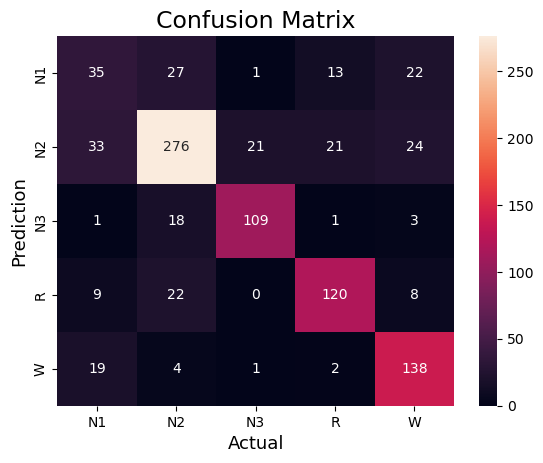

In [20]:
confusion_matrix_test = confusion_matrix(y_test, y_pred)
confusion_matrix_test = pd.DataFrame(confusion_matrix_test, index=labels, columns=labels)

#Plot the confusion matrix.
sns.heatmap(confusion_matrix_test,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

# Logistic

In [ ]:
# train a multi classification logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1000)
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', solver='saga')

In [ ]:
# Predicting training and testing sets
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Calculate the accuracy of training and testing sets
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

# Calculate Kappa coefficient
kappa_train = cohen_kappa_score(y_train, y_train_pred)
kappa_test = cohen_kappa_score(y_test, y_test_pred)

# Calculate confusion matrix
confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
confusion_matrix_train = pd.DataFrame(confusion_matrix_train, index=labels, columns=labels)
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
confusion_matrix_test = pd.DataFrame(confusion_matrix_test, index=labels, columns=labels)

In [ ]:
# print train result
print(f'Train Accuracy: {accuracy_train:.2f}')

print(f'Train Kappa: {kappa_train:.2f}')

print('Train Confusion Matrix:')
print(confusion_matrix_train)

print_class_accuracy(y_train, y_train_pred, "Training")

Train Accuracy: 0.59
Train Kappa: 0.48
Train Confusion Matrix:
     N1   N2   N3    R    W
N1  234  206   11   84  165
N2   94  597   99  154   56
N3    1   97  565   31    6
R    66  216   28  347   25
W    95   77   15   51  515
Training Dataset:
Accuracy for class N1: 33.43%
Accuracy for class N2: 59.70%
Accuracy for class N3: 80.71%
Accuracy for class R: 50.88%
Accuracy for class W: 68.39%


In [ ]:
# print test result
print(f'Test Accuracy: {accuracy_test:.2f}')

print(f'Test Kappa: {kappa_test:.2f}')

print('Test Confusion Matrix:')
print(confusion_matrix_test)

print_class_accuracy(y_test, y_test_pred, "Testing")

Test Accuracy: 0.59
Test Kappa: 0.45
Test Confusion Matrix:
    N1   N2   N3   R    W
N1  30   23    5  17   23
N2  31  227   33  57   27
N3   2   16  106   6    2
R   16   57    5  76    5
W   21   13    5  19  106
Testing Dataset:
Accuracy for class N1: 30.61%
Accuracy for class N2: 60.53%
Accuracy for class N3: 80.30%
Accuracy for class R: 47.80%
Accuracy for class W: 64.63%


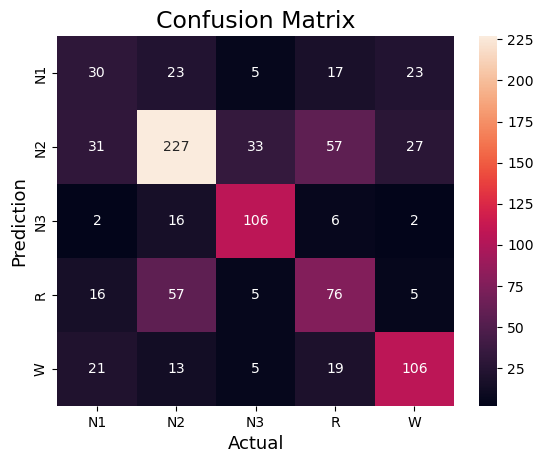

In [ ]:
#Plot the confusion matrix.
sns.heatmap(confusion_matrix_test,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [ ]:
result['Accuracy'].append(accuracy_test*100)
result['Stage'].append('Total')

conf_matrix = confusion_matrix(y_test, y_test_pred)
class_accuracy = 100 * conf_matrix.diagonal() / np.maximum(conf_matrix.sum(axis=1), 1)
labels = np.unique(np.concatenate((y_test, y_test_pred)))

for label, accuracy in zip(labels, class_accuracy):
    result['Accuracy'].append(accuracy)
    result['Stage'].append(label)

result['Method'].extend(['LR' for _ in range(6)])

# SVM

In [ ]:
clf = SVC(kernel='linear', gamma='auto')

clf.fit(X_train_scaled, y_train)


y_train_pred = clf.predict(X_train_scaled)
y_test_pred = clf.predict(X_test_scaled)


train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_kappa = cohen_kappa_score(y_train, y_train_pred)
test_kappa = cohen_kappa_score(y_test, y_test_pred)


train_confusion = confusion_matrix(y_train, y_train_pred)
test_confusion = confusion_matrix(y_test, y_test_pred)

print(f"Results for {'linear'} kernel:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Training Kappa: {train_kappa:.4f}")
print(f"Testing Kappa: {test_kappa:.4f}")
print("Training Confusion Matrix:")
print(train_confusion)
print("Testing Confusion Matrix:")
print(test_confusion)
print_class_accuracy(y_train, y_train_pred, "Training")
print_class_accuracy(y_test, y_test_pred, "Testing")
print("\n")

Results for linear kernel:
Training Accuracy: 0.5950
Testing Accuracy: 0.5819
Training Kappa: 0.4893
Testing Kappa: 0.4511
Training Confusion Matrix:
[[280 181  11  90 138]
 [114 574  86 172  54]
 [  2  99 567  26   6]
 [ 69 207  22 358  26]
 [144  54   9  43 503]]
Testing Confusion Matrix:
[[ 34  24   3  16  21]
 [ 41 216  31  65  22]
 [  3  18 103   5   3]
 [ 19  47   4  83   6]
 [ 37  14   1   8 104]]
Training Dataset:
Accuracy for class N1: 40.00%
Accuracy for class N2: 57.40%
Accuracy for class N3: 81.00%
Accuracy for class R: 52.49%
Accuracy for class W: 66.80%
Testing Dataset:
Accuracy for class N1: 34.69%
Accuracy for class N2: 57.60%
Accuracy for class N3: 78.03%
Accuracy for class R: 52.20%
Accuracy for class W: 63.41%




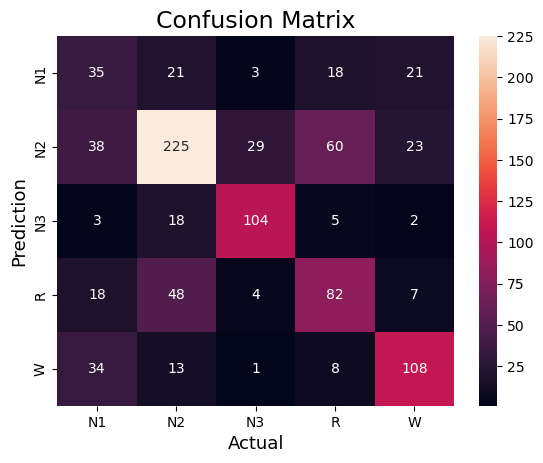

In [22]:
test_confusion = pd.DataFrame(test_confusion, index=labels, columns=labels)

#Plot the confusion matrix.
sns.heatmap(test_confusion,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [ ]:
result['Accuracy'].append(test_accuracy*100)
result['Stage'].append('Total')

conf_matrix = confusion_matrix(y_test, y_test_pred)
class_accuracy = 100 * conf_matrix.diagonal() / np.maximum(conf_matrix.sum(axis=1), 1)
labels = np.unique(np.concatenate((y_test, y_test_pred)))

for label, accuracy in zip(labels, class_accuracy):
    result['Accuracy'].append(accuracy)
    result['Stage'].append(label)

result['Method'].extend(['SVM' for _ in range(6)])

# kNN

In [ ]:
# Define KNN model
knn = KNeighborsClassifier()

# Set the range of k values to search 
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

# Search using cross validation
cv = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
cv.fit(X_train_scaled, y_train)
#Obtain the average cross validation score corresponding to each k value
mean_scores = cv.cv_results_['mean_test_score']

# Output the optimal k value
print('Best k:', cv.best_params_['n_neighbors'])

Best k: 1


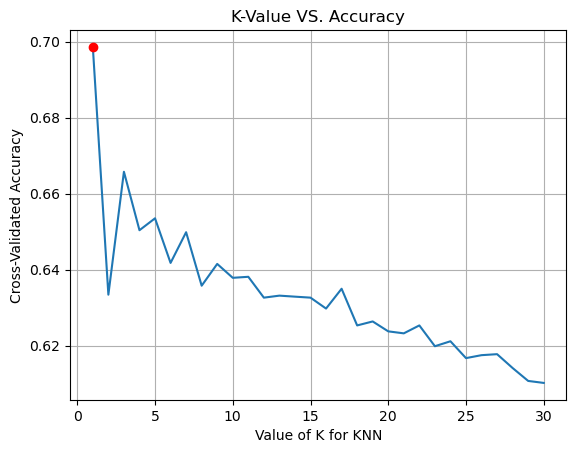

In [ ]:
# Draw a graph of k values and cross validation accuracy
plt.figure()
plt.plot(k_range, mean_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.title('K-Value VS. Accuracy')

# Highlight the optimal k-value point
best_k = cv.best_params_['n_neighbors']
best_score = max(mean_scores)
plt.scatter(best_k, best_score, color='red', zorder=5)
plt.grid(True)
plt.show()

In [ ]:
# Use the best k value
knn_best = KNeighborsClassifier(n_neighbors=1)
knn_best.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=1)

In [ ]:
y_pred = knn_best.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Confusion Matrix:
[[ 28  33   2  14  21]
 [ 40 222  40  54  19]
 [  1  22 103   4   2]
 [ 22  35   3  91   8]
 [ 32  13   2  12 105]]
Accuracy: 0.5915948275862069


In [ ]:
print_class_accuracy(y_test, y_pred, "Testing")

Testing Dataset:
Accuracy for class N1: 28.57%
Accuracy for class N2: 59.20%
Accuracy for class N3: 78.03%
Accuracy for class R: 57.23%
Accuracy for class W: 64.02%


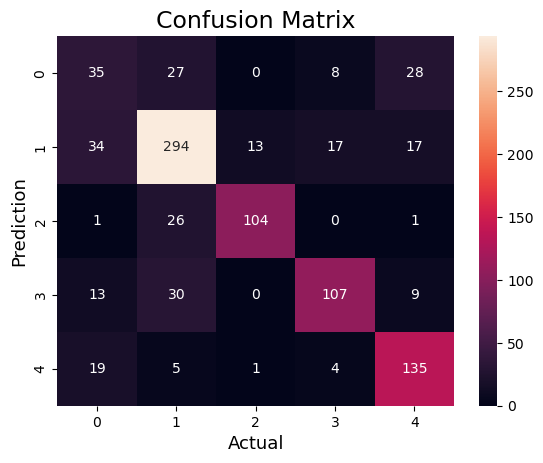

In [ ]:
#Plot the confusion matrix.
sns.heatmap(conf_matrix,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [ ]:
result['Accuracy'].append(accuracy*100)
result['Stage'].append('Total')

conf_matrix = confusion_matrix(y_test, y_pred)
class_accuracy = 100 * conf_matrix.diagonal() / np.maximum(conf_matrix.sum(axis=1), 1)
labels = np.unique(np.concatenate((y_test, y_pred)))

for label, accuracy in zip(labels, class_accuracy):
    result['Accuracy'].append(accuracy)
    result['Stage'].append(label)

result['Method'].extend(['KNN' for _ in range(6)])

# NN

In [13]:
label_encoder = LabelEncoder()
y_encoded_train = label_encoder.fit_transform(y_train)
y_encoded_test = label_encoder.fit_transform(y_test)

X_tensor_train = torch.tensor(X_train_scaled)  # Adding channel dimension
y_tensor_train = torch.tensor(y_encoded_train, dtype=torch.long)

X_tensor_test = torch.tensor(X_test_scaled)  # Adding channel dimension
y_tensor_test = torch.tensor(y_encoded_test, dtype=torch.long)

In [14]:
# Create DataLoaders for train and validation sets
train_dataloader = DataLoader(TensorDataset(X_tensor_train, y_tensor_train), batch_size=32, shuffle=True)
val_dataloader = DataLoader(TensorDataset(X_tensor_test, y_tensor_test), batch_size=32, shuffle=False)

In [15]:
# Function to calculate accuracy
def calculate_accuracy(dataloader,model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            outputs = model(inputs.float())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [16]:
class MultiClassNetwork(nn.Module):
    def __init__(self, num_classes):
        super(MultiClassNetwork, self).__init__()
        self.fc1 = nn.Linear(22, 128)
        self.bn1 = nn.BatchNorm1d(128)  
        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)  
        #self.fc3 = nn.Linear(256, 200)
       # self.bn3 = nn.BatchNorm1d(200)  
        self.fc4 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)  
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)  
        x = F.relu(x)
        #x = self.fc3(x)
        #x = self.bn3(x)  #
        #x = F.relu(x)
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)


In [20]:
num_classes = 5
model = MultiClassNetwork(num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    train_acc = calculate_accuracy(train_dataloader,model)
    val_acc = calculate_accuracy(val_dataloader,model)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Train acc: {train_acc}, Val acc: {val_acc}')

Epoch 1/15, Loss: 1.0394434928894043, Train acc: 0.6432855280312908, Val acc: 0.5948275862068966
Epoch 2/15, Loss: 0.7631656527519226, Train acc: 0.6774445893089961, Val acc: 0.6400862068965517
Epoch 3/15, Loss: 0.7411239147186279, Train acc: 0.7126466753585398, Val acc: 0.6637931034482759
Epoch 4/15, Loss: 0.977850615978241, Train acc: 0.7348109517601042, Val acc: 0.6702586206896551
Epoch 5/15, Loss: 0.978772759437561, Train acc: 0.748109517601043, Val acc: 0.6702586206896551
Epoch 6/15, Loss: 0.7137036323547363, Train acc: 0.7371577574967405, Val acc: 0.6928879310344828
Epoch 7/15, Loss: 0.6105046272277832, Train acc: 0.7726205997392438, Val acc: 0.6476293103448276
Epoch 8/15, Loss: 0.6527445912361145, Train acc: 0.7835723598435462, Val acc: 0.7230603448275862
Epoch 9/15, Loss: 0.7731680274009705, Train acc: 0.7723598435462842, Val acc: 0.6573275862068966
Epoch 10/15, Loss: 0.6952471733093262, Train acc: 0.7663624511082138, Val acc: 0.6637931034482759
Epoch 11/15, Loss: 0.45890215039

In [ ]:
# Evaluate the model to calculate accuracy and confusion matrix
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in val_dataloader:
        inputs = inputs.float()  # Ensure that the input data is of type Float
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy}')

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.740301724137931
Confusion Matrix:
[[ 25  35   0  14  24]
 [ 24 281  26  27  17]
 [  1  21 110   0   0]
 [  5  15   0 134   5]
 [ 18   6   1   2 137]]


In [ ]:
print_class_accuracy(all_labels, all_preds, "Testing")

Testing Dataset:
Accuracy for class 0: 25.51%
Accuracy for class 1: 74.93%
Accuracy for class 2: 83.33%
Accuracy for class 3: 84.28%
Accuracy for class 4: 83.54%


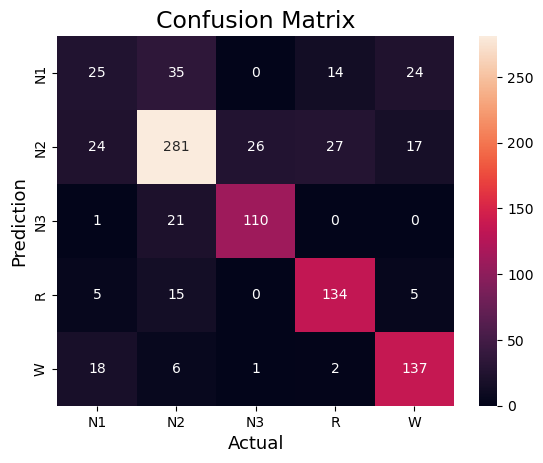

In [25]:
conf_matrix = pd.DataFrame(conf_matrix, index=labels, columns=labels)

#Plot the confusion matrix.
sns.heatmap(conf_matrix,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [ ]:
result['Accuracy'].append(accuracy*100)
result['Stage'].append('Total')

class_accuracy = 100 * conf_matrix.diagonal() / np.maximum(conf_matrix.sum(axis=1), 1)
labels = np.unique(np.concatenate((all_labels, all_preds)))

for label, accuracy in zip(labels, class_accuracy):
    result['Accuracy'].append(accuracy)
    result['Stage'].append(label)

result['Method'].extend(['NN' for _ in range(6)])

In [ ]:
results = pd.DataFrame(result)

In [ ]:
results.to_csv('results.csv',index = False)

In [ ]:
results = pd.read_csv('results.csv')

In [ ]:
# Adjusting the pivot table and plot to group by 'Method', color by 'Stage', and display only group names in the legend
pivot_table = results.pivot_table(index='Method', columns='Stage', values='Accuracy', aggfunc='mean')

pivot_table = pivot_table[['Total'] + [col for col in pivot_table.columns if col != 'Total']]

In [ ]:
pivot_table

Stage,Total,N1,N2,N3,R,W
Method,,,,,,
LR,58.728448,30.612245,60.533333,80.303030,47.798742,64.634146
NN,74.030172,25.510000,74.930000,83.330000,84.280000,83.540000
RF,73.706897,37.760000,74.640000,81.060000,76.100000,84.760000
SVM,58.189655,34.693878,57.600000,78.030303,52.201258,63.414634


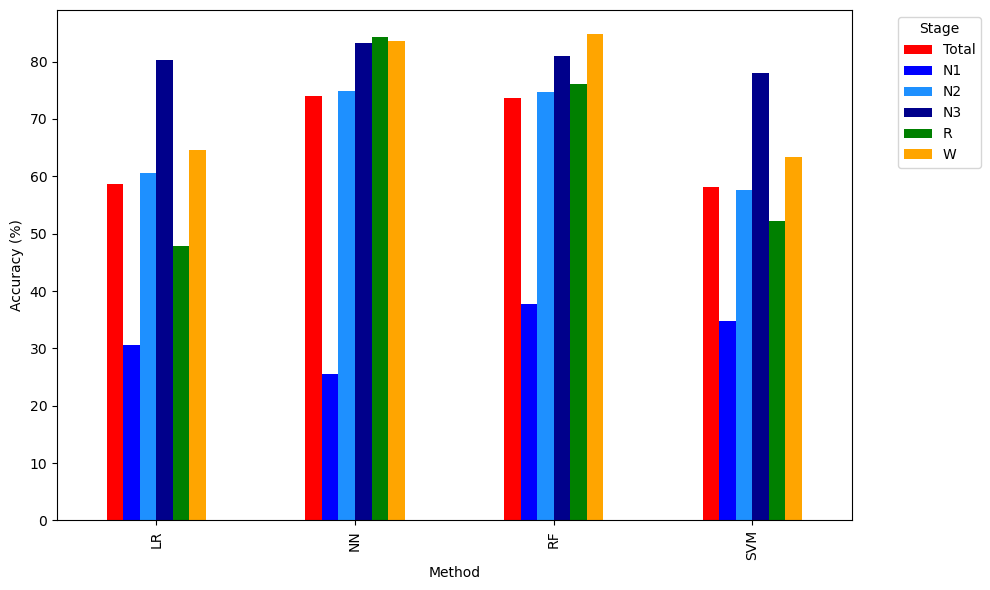

In [ ]:
# Defining custom colors
custom_colors = {
    'Total': 'red',
    'N1': 'blue',
    'N2': 'dodgerblue',
    'N3': 'darkblue',
    'R': 'green',
    'W': 'orange'
}
# Enlarging the plot size for better clarity
plt.figure(figsize=(10, 6))

# Replotting the chart with the improved color palette
pivot_table.plot(kind='bar', stacked=False, color=[custom_colors[stage] for stage in pivot_table.columns], ax=plt.gca())
plt.xlabel('Method')
plt.ylabel('Accuracy (%)')
#plt.title('Grouped Bar Chart by Method and Stage with Optimized Colors')
plt.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# PCA

In [14]:
from sklearn.decomposition import PCA

In [73]:
# Fit PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

pca = PCA().fit(X_scaled)

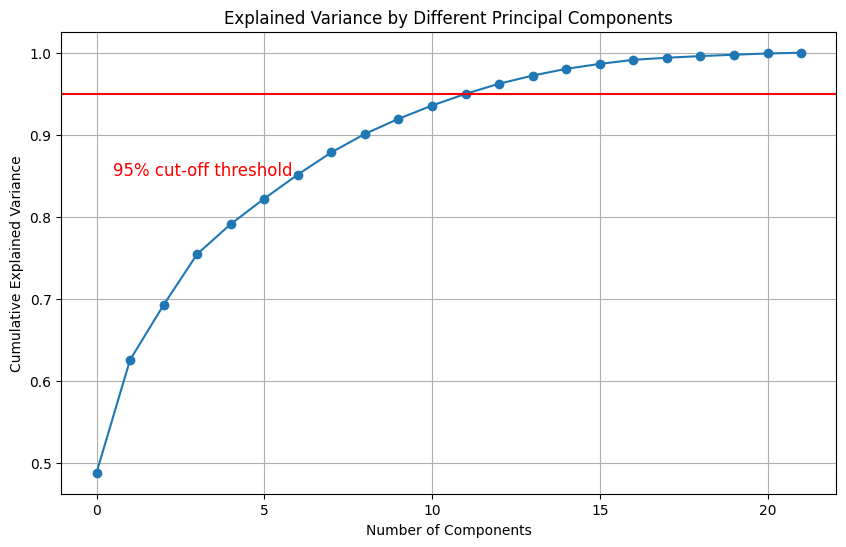

13

In [74]:
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
n_components_for_95_variance = np.argmax(cumulative_variance_ratio >= 0.95) + 1

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Different Principal Components')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=12)
plt.grid(True)
plt.show()

n_components_for_95_variance

In [36]:
pca = PCA(n_components=11)
X_pca = pca.fit_transform(X_scaled)

In [37]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=24)

In [39]:
over_strategy = {'N1': 700, 'N3': 700}
under_strategy = {'N2': 1000}
over = SMOTE(sampling_strategy=over_strategy)
under = RandomUnderSampler(sampling_strategy=under_strategy)

pipeline_resample = Pipeline(steps=[('o', over) , ('u' , under)])


X_resampled, y_resampled = pipeline_resample.fit_resample(X_train, y_train)
y_train = y_resampled
X_train = X_resampled

In [62]:
label_encoder = LabelEncoder()
y_encoded_train = label_encoder.fit_transform(y_train)
y_encoded_test = label_encoder.fit_transform(y_test)

X_tensor_train = torch.tensor(X_train)
y_tensor_train = torch.tensor(y_encoded_train, dtype=torch.long)

X_tensor_test = torch.tensor(X_test)
y_tensor_test = torch.tensor(y_encoded_test, dtype=torch.long)

In [63]:
# Create DataLoaders for train and validation sets
train_dataloader = DataLoader(TensorDataset(X_tensor_train, y_tensor_train), batch_size=32, shuffle=True)
val_dataloader = DataLoader(TensorDataset(X_tensor_test, y_tensor_test), batch_size=32, shuffle=False)

In [70]:
# Define a neural network
class NN_PCA(nn.Module):
    def __init__(self):
        super(NN_PCA, self).__init__()
        self.fc1 = nn.Linear(11, 128)
        self.bn1 = nn.BatchNorm1d(128)  
        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)  
        self.fc3 = nn.Linear(256, 150)
        self.bn3 = nn.BatchNorm1d(150)  
        self.fc4 = nn.Linear(150, 5)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)  
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)  
        x = F.relu(x)
        x = self.fc3(x)
        x = self.bn3(x)  
        x = F.relu(x)
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)

In [71]:

# Instantiate the model, define loss function and optimizer
model = NN_PCA()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [75]:
# Training loop with accuracy evaluation per epoch
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    train_acc = calculate_accuracy(train_dataloader,model)
    val_acc = calculate_accuracy(val_dataloader,model)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Train acc: {train_acc}, Val acc: {val_acc}')

Epoch 1/10, Loss: 1.0016206502914429, Train acc: 0.8221642764015645, Val acc: 0.6185344827586207
Epoch 2/10, Loss: 1.1953284740447998, Train acc: 0.8338983050847457, Val acc: 0.6196120689655172
Epoch 3/10, Loss: 0.5412125587463379, Train acc: 0.842503259452412, Val acc: 0.5980603448275862
Epoch 4/10, Loss: 0.8822850584983826, Train acc: 0.8492829204693612, Val acc: 0.6163793103448276
Epoch 5/10, Loss: 0.6745414137840271, Train acc: 0.8576271186440678, Val acc: 0.6336206896551724
Epoch 6/10, Loss: 0.5142504572868347, Train acc: 0.8646675358539765, Val acc: 0.6497844827586207
Epoch 7/10, Loss: 0.5725838541984558, Train acc: 0.8482398956975228, Val acc: 0.6163793103448276
Epoch 8/10, Loss: 0.88225257396698, Train acc: 0.8586701434159061, Val acc: 0.6131465517241379
Epoch 9/10, Loss: 0.4502094089984894, Train acc: 0.8672750977835724, Val acc: 0.6012931034482759
Epoch 10/10, Loss: 0.38187500834465027, Train acc: 0.878748370273794, Val acc: 0.5980603448275862


In [76]:
# Evaluate the model to calculate accuracy and confusion matrix
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in val_dataloader:
        inputs = inputs.float()  
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy}')

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.5980603448275862
Confusion Matrix:
[[ 32  20   1  21  24]
 [ 44 193  44  69  25]
 [  2  14 110   4   2]
 [ 18  27   1 107   6]
 [ 35   9   4   3 113]]


In [77]:
print_class_accuracy(all_labels, all_preds, "Testing")

Testing Dataset:
Accuracy for class 0: 32.65%
Accuracy for class 1: 51.47%
Accuracy for class 2: 83.33%
Accuracy for class 3: 67.30%
Accuracy for class 4: 68.90%
